### Compare results of the different models

In [1]:
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import stat
import numpy as np

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Aggregate all results in one file

In [3]:
path = 'data/PROCESSED/MODEL_OUTPUTS'

In [4]:
r = re.compile(f'.*_performance_overall.csv$') # only csv files
files = list(filter(r.match, os.listdir(path))) 
res = sorted(files)

In [5]:
results = pd.DataFrame()
for f in range(len(res)):
    df = pd.read_csv(f'{path}/{res[f]}')
    df['epochs'] = df['Unnamed: 0'].apply(lambda row: int(row.split('_')[-1]) if row.split('_')[-1] in ['50','100','150','250'] else 20)
    df['window'] = df['Unnamed: 0'].apply(lambda row: row.split('_')[-3]+'_'+row.split('_')[-2] if row.split('_')[-1] in ['50','100','150','250'] else row.split('_')[-2]+'_'+row.split('_')[-1])
    df['freq'] = df['Unnamed: 0'].apply(lambda row: row.split('_')[-4] if row.split('_')[-1] in ['50','100','150','250'] else row.split('_')[-3])
    df['model'] = df['Unnamed: 0'].apply(lambda row: row.split('_')[0])
    df['station'] =res[f].split('_')[0]
    results = results.append(df)

In [6]:
results = results[~results['model'].isin(['BaselineLast','BaselineRepeat'])]

### ANOVA Window

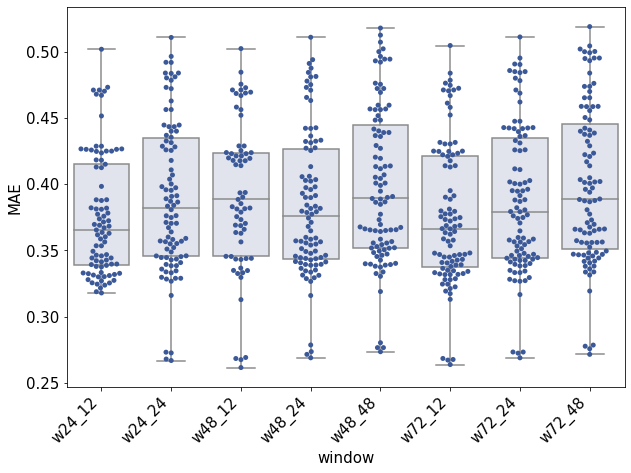

In [123]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.boxplot(x='window', y='mae_test', data=results, color='#DFE3EE')
ax = sns.swarmplot(x="window", y="mae_test", data=results, color='#3B5998')
ax.set_xlabel("window",fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels=results.window.unique(),rotation = 45, ha="right")
plt.show()
fig.savefig(f'{path}/boxplot_window.png',dpi = 75)

In [71]:
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test ~ C(window)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(window),7.0,0.048454,0.006922,2.292332,0.02589
Residual,672.0,2.029185,0.003020,NaN,NaN


In [72]:
res = stat()
res.tukey_hsd(df=results, res_var='mae_test', xfac_var='window', anova_model='mae_test ~ C(window)')
test = res.tukey_summary
test[test['p-value']<0.05]

,group1,group2,Diff,Lower,Upper,q-value,p-value


In [60]:
#### No significant differences

### ANOVA Model

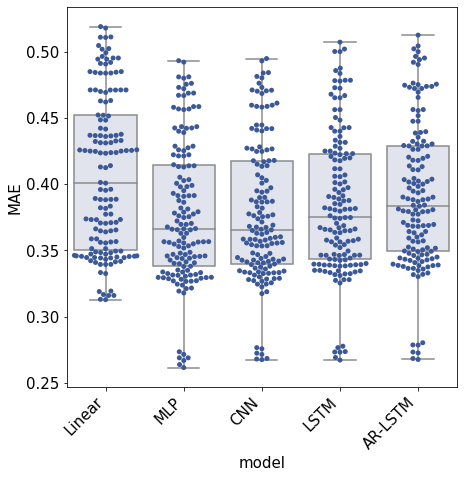

In [135]:
fig, ax = plt.subplots(figsize = (7,7))
ax = sns.boxplot(x='model', y='mae_test', data=results, color='#DFE3EE')
ax = sns.swarmplot(x='model', y="mae_test", data=results, color='#3B5998')
ax.set_xlabel('model',fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels=['Linear', 'MLP', 'CNN', 'LSTM', 'AR-LSTM'],rotation = 45, ha="right")
plt.show()
fig.savefig(f'{path}/boxplot_model.png',dpi = 75,bbox_inches='tight')

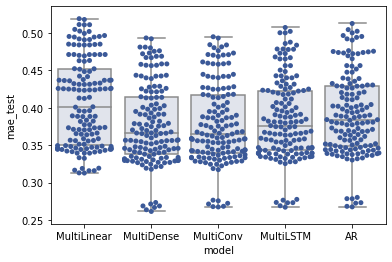

In [94]:
ax = sns.boxplot(x='model', y='mae_test', data=results, color='#DFE3EE')
ax = sns.swarmplot(x="model", y="mae_test", data=results, color='#3B5998')
plt.show()

In [74]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test ~ C(model)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(model),4.0,0.080595,0.020149,6.81029,0.000022
Residual,675.0,1.997043,0.002959,NaN,NaN


In [75]:
res = stat()
res.tukey_hsd(df=results, res_var='mae_test', xfac_var='model', anova_model='mae_test ~ C(model)')
test = res.tukey_summary
test[test['p-value']<0.05]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,MultiLinear,MultiDense,0.029717,0.011675,0.047758,6.371308,0.001000
1,MultiLinear,MultiConv,0.028906,0.010864,0.046947,6.197391,0.001000
2,MultiLinear,MultiLSTM,0.022006,0.003965,0.040048,4.718171,0.007952


In [45]:
####  MultiLinear is worse than others. No signiff difference in 

### ANOVA Agregagtion

In [76]:
results.station.unique()

array(['AJSucre', 'JAlvarez', 'aeropuerto', 'all', 'ambato', 'banos',
       'calamaca', 'chiquiurco', 'cutuchi', 'guadalupe', 'high', 'low',
       'medium', 'mulaCorral', 'pastaza', 'patate', 'pisayambo',
       'quisapincha', 'tasinteo'], dtype=object)

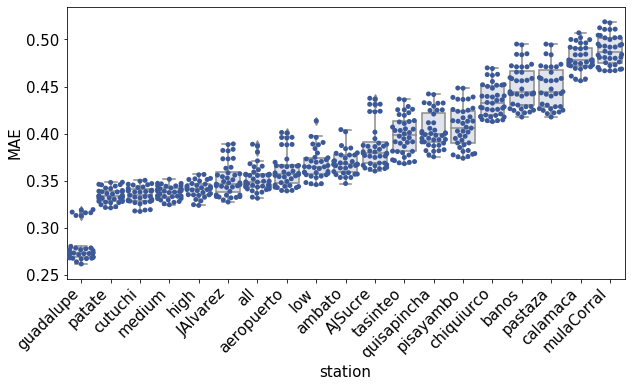

In [133]:
grouped = results.loc[:,['station', 'mae_test']] \
    .groupby(['station']) \
    .median() \
    .sort_values(by='mae_test')

fig, ax =plt.subplots(figsize=(10,5))
ax = sns.boxplot(x='station', y='mae_test', data=results, color='#DFE3EE',order=grouped.index)
ax = sns.swarmplot(x="station", y="mae_test", data=results, color='#3B5998',order=grouped.index)
ax.set_xlabel('station',fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels = grouped.index,rotation = 45, ha="right")
plt.show()

plt.show()
fig.savefig(f'{path}/boxplot_stations.png',dpi = 75,bbox_inches='tight')

In [104]:
groups = results[results.station.isin(['all','high','medium','low','cutuchi','patate','pastaza','ambato'])]

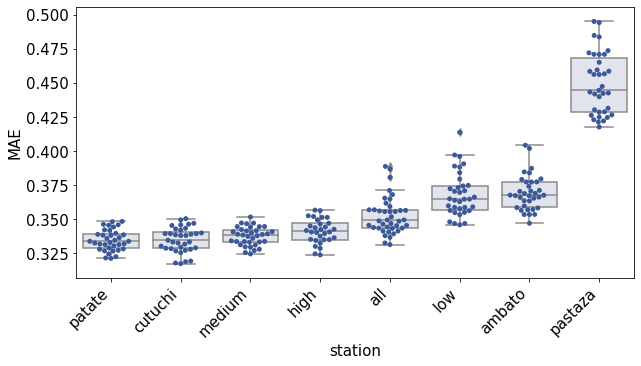

In [134]:
grouped = groups.loc[:,['station', 'mae_test']] \
    .groupby(['station']) \
    .median() \
    .sort_values(by='mae_test')

fig, ax =plt.subplots(figsize=(10,5))
ax = sns.boxplot(x='station', y='mae_test', data=groups, color='#DFE3EE',order=grouped.index)
ax = sns.swarmplot(x="station", y="mae_test", data=groups, color='#3B5998',order=grouped.index)
ax.set_xlabel('station',fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels = grouped.index,rotation = 45, ha="right")
plt.show()

plt.show()
fig.savefig(f'{path}/boxplot_groups.png',dpi = 75,bbox_inches='tight')

In [106]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=groups, res_var='mae_test', anova_model='mae_test ~ C(station)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(station),7.0,0.361819,0.051688,298.379984,1.156336e-123
Residual,272.0,0.047119,0.000173,NaN,NaN


In [108]:
res = stat()
res.tukey_hsd(df=groups, res_var='mae_test', xfac_var='station', anova_model='mae_test ~ C(station)')
test = res.tukey_summary
test[test['p-value']<0.05]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,all,ambato,0.016989,0.007683,0.026294,7.886654,0.001000
1,all,cutuchi,0.017593,0.008287,0.026898,8.167232,0.001000
2,all,high,0.011103,0.001393,0.020813,4.939615,0.012841
3,all,low,0.015931,0.006626,0.025237,7.395815,0.001000
4,all,medium,0.014831,0.005526,0.024137,6.885179,0.001000
5,all,pastaza,0.097279,0.087973,0.106584,45.159964,0.001000
6,all,patate,0.017813,0.008508,0.027119,8.269412,0.001000
7,ambato,cutuchi,0.034581,0.024971,0.044192,15.544109,0.001000
8,ambato,high,0.028092,0.018089,0.038095,12.131653,0.001000
10,ambato,medium,0.031820,0.022209,0.041430,14.302766,0.001000


### 2 way ANOVA model + window

In [8]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test~C(model)+C(window)+C(model):C(window)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(model),4.0,0.087820,0.021955,7.061015,0.000014
C(window),7.0,0.048397,0.006914,2.223567,0.030709
C(model):C(window),28.0,0.004489,0.000160,0.051557,1.000000
Residual,670.0,2.083257,0.003109,NaN,NaN


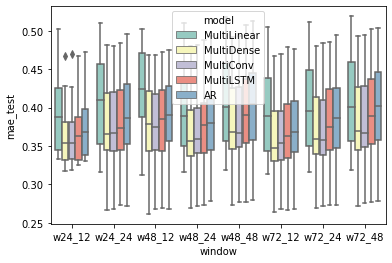

In [12]:
sns.boxplot(x="window", y="mae_test", hue="model", data=results, palette="Set3") 

### 2 way ANOVA window + station

In [10]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test~C(window)+C(station)+C(window):C(station)')
res.anova_summary
### There is no intercation model/window

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 15
  'rank is %d' % (J, J_), ValueWarning)
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 126, but rank is 118
  'rank is %d' % (J, J_), ValueWarning)


,df,sum_sq,mean_sq,F,PR(>F)
C(window),7.0,0.056934,0.008133,34.330955,6.197033e-40
C(station),18.0,1.575072,0.087504,369.351136,2.958816e-281
C(window):C(station),126.0,0.756582,0.006005,25.345283,4.768277e-165
Residual,568.0,0.134566,0.000237,NaN,NaN


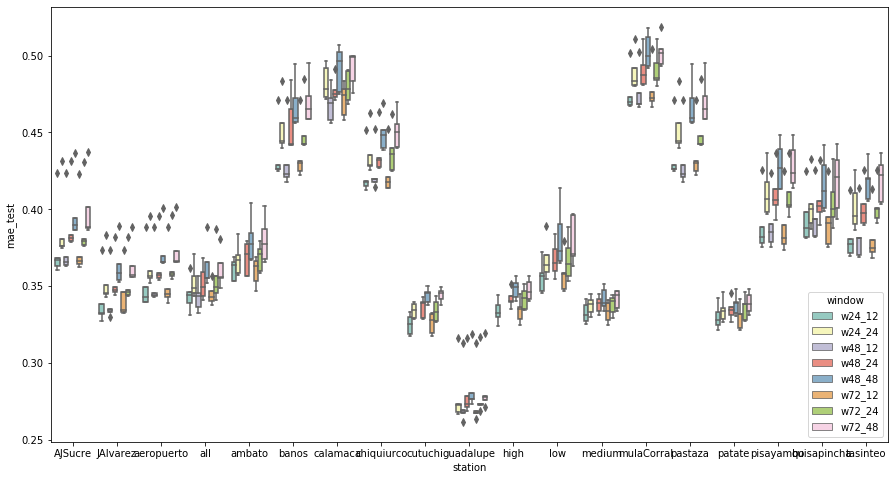

In [16]:
plt.figure(figsize=(15,8))
sns.boxplot(x="station", y="mae_test", hue="window", data=results, palette="Set3") 

### 2 way ANOVA model + station

In [9]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test~C(model)+C(station)+C(model):C(station)')
res.anova_summary
### There is no intercation model/window

,df,sum_sq,mean_sq,F,PR(>F)
C(model),4.0,0.087820,0.021955,185.551093,3.303560e-104
C(station),18.0,2.023458,0.112414,950.057897,0.000000e+00
C(model):C(station),72.0,0.039915,0.000554,4.685261,6.962882e-27
Residual,615.0,0.072769,0.000118,NaN,NaN


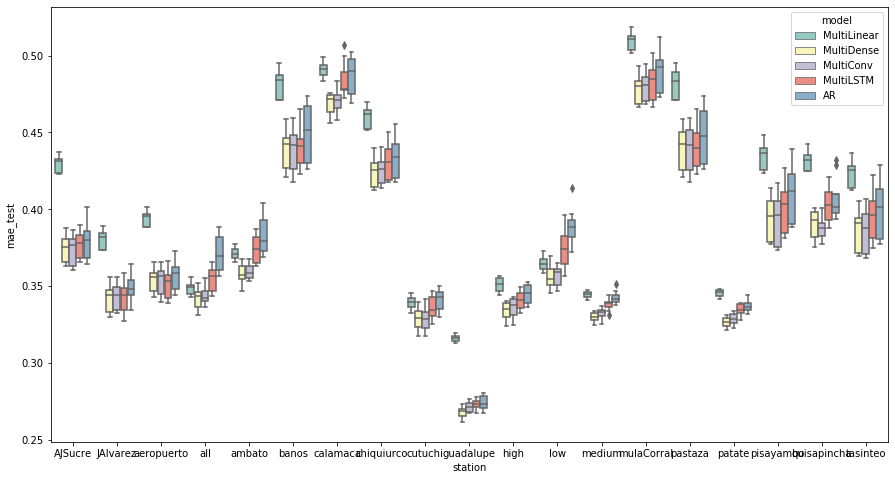

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(x="station", y="mae_test", hue="model", data=results, palette="Set3") 

### ANOVA time

In [8]:
### 4 stations 60, 30, 15 and 5 minutes for 48 +24h predictions
results.window.unique()

array(['w24_12', 'w24_24', 'w48_12', 'w48_24', 'w48_48', 'w72_12',
       'w72_24', 'w72_48', 'w576_288', '24_20', 'w192_96', 'w96_48'],
      dtype=object)

In [9]:
results.window = results.window.replace(to_replace = ['w576_288','w192_96', 'w96_48'], value = 'w48_24')

In [13]:
df = results[(results['window'] == 'w48_24') & 
        (results['station'].isin(['guadalupe','baños','mulaCorral','quisapincha'])) & 
        (results['model']=='MultiLSTM') & (results['epochs']==20)]

In [14]:
df

,Unnamed: 0,loss_test,mae_test,loss_val,mae_val,epochs,window,freq,model,station
0,MultiLSTM_model_15m_w192_96,0.276341,0.271544,0.329214,0.312905,20,w48_24,15m,MultiLSTM,guadalupe
0,MultiLSTM_model_30m_w96_48,0.275769,0.273131,0.329437,0.313102,20,w48_24,30m,MultiLSTM,guadalupe
0,MultiLSTM_model_5m_w576_288,0.283038,0.273182,0.340439,0.315666,20,w48_24,5m,MultiLSTM,guadalupe
4,MultiLSTM_model_60m_w48_24,0.275618,0.273560,0.328397,0.315269,20,w48_24,60m,MultiLSTM,guadalupe
0,MultiLSTM_model_15m_w192_96,0.601342,0.475671,0.604503,0.457843,20,w48_24,15m,MultiLSTM,mulaCorral
0,MultiLSTM_model_30m_w96_48,0.604446,0.478184,0.595224,0.457835,20,w48_24,30m,MultiLSTM,mulaCorral
0,MultiLSTM_model_5m_w576_288,0.597058,0.470995,0.616320,0.458839,20,w48_24,5m,MultiLSTM,mulaCorral
4,MultiLSTM_model_60m_w48_24,0.612981,0.487472,0.602100,0.468679,20,w48_24,60m,MultiLSTM,mulaCorral
0,MultiLSTM_model_15m_w192_96,0.466806,0.402464,0.429982,0.382199,20,w48_24,15m,MultiLSTM,quisapincha
0,MultiLSTM_model_30m_w96_48,0.474784,0.404648,0.432624,0.385006,20,w48_24,30m,MultiLSTM,quisapincha


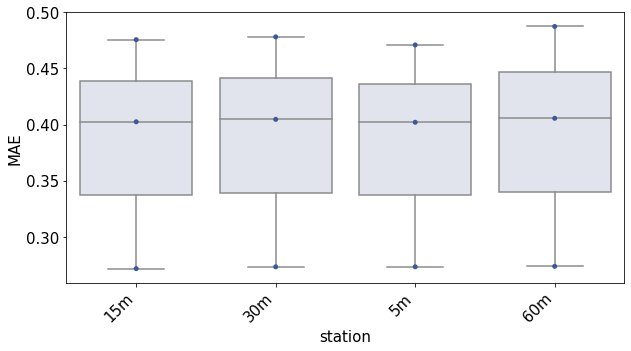

In [15]:
fig, ax =plt.subplots(figsize=(10,5))
ax = sns.boxplot(x='freq', y='mae_test', data=df, color='#DFE3EE')
ax = sns.swarmplot(x="freq", y="mae_test", data=df, color='#3B5998')
ax.set_xlabel('station',fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels = df.freq.unique(),rotation = 45, ha="right")
plt.show()

plt.show()
fig.savefig(f'{path}/boxplot_freqs.png',dpi = 75,bbox_inches='tight')

In [18]:
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test ~ C(freq)')
res.anova_summary
### No significant difference. We keep hourly predictions

,df,sum_sq,mean_sq,F,PR(>F)
C(freq),3.0,0.000325,0.000108,0.033858,0.99164
Residual,716.0,2.289261,0.003197,NaN,NaN


### ANOVA epochs

In [16]:
### 4 stations 60, 30, 15 and 5 minutes for 48 +24h predictions
results.epochs.unique()

array([ 20, 100, 250,  50, 150])

In [26]:
df = results[(results['window'] == 'w48_24') & 
        (results['station'].isin(['guadalupe','baños','mulaCorral','quisapincha'])) & 
        (results['model']=='MultiLSTM')]

In [29]:
df= df[(df['epochs'] != 150)  & (df['freq'] == '60m')]

In [30]:
df

,Unnamed: 0,loss_test,mae_test,loss_val,mae_val,epochs,window,freq,model,station
0,MultiLSTM_model_60m_w48_24_100,0.276065,0.274050,0.329681,0.318016,100,w48_24,60m,MultiLSTM,guadalupe
0,MultiLSTM_model_60m_w48_24_250,0.277113,0.273634,0.334135,0.317318,250,w48_24,60m,MultiLSTM,guadalupe
0,MultiLSTM_model_60m_w48_24_50,0.274463,0.273793,0.331377,0.318425,50,w48_24,60m,MultiLSTM,guadalupe
4,MultiLSTM_model_60m_w48_24,0.275618,0.273560,0.328397,0.315269,20,w48_24,60m,MultiLSTM,guadalupe
0,MultiLSTM_model_60m_w48_24_100,0.608956,0.484971,0.600186,0.467660,100,w48_24,60m,MultiLSTM,mulaCorral
0,MultiLSTM_model_60m_w48_24_250,0.608108,0.483323,0.599340,0.463206,250,w48_24,60m,MultiLSTM,mulaCorral
0,MultiLSTM_model_60m_w48_24_50,0.611054,0.485654,0.597371,0.465570,50,w48_24,60m,MultiLSTM,mulaCorral
4,MultiLSTM_model_60m_w48_24,0.612981,0.487472,0.602100,0.468679,20,w48_24,60m,MultiLSTM,mulaCorral
0,MultiLSTM_model_60m_w48_24_100,0.476138,0.404731,0.431022,0.385071,100,w48_24,60m,MultiLSTM,quisapincha
0,MultiLSTM_model_60m_w48_24_250,0.478607,0.407073,0.428681,0.387155,250,w48_24,60m,MultiLSTM,quisapincha


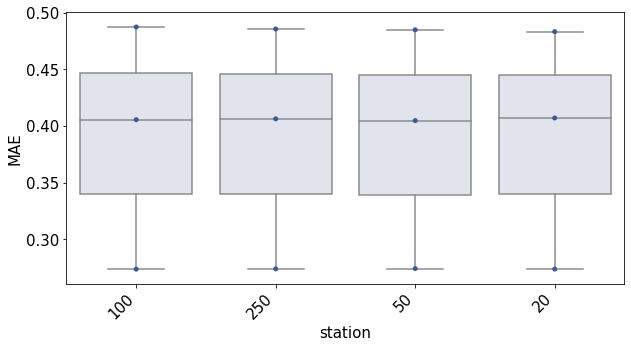

In [32]:
fig, ax =plt.subplots(figsize=(10,5))
ax = sns.boxplot(x='epochs', y='mae_test', data=df, color='#DFE3EE')
ax = sns.swarmplot(x="epochs", y="mae_test", data=df, color='#3B5998')
ax.set_xlabel('station',fontsize=15)
ax.set_ylabel("MAE",fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xticklabels(labels = df.epochs.unique(),rotation = 45, ha="right")
plt.show()

plt.show()
fig.savefig(f'{path}/boxplot_epochs.png',dpi = 75,bbox_inches='tight')

In [95]:
res = stat()
res.anova_stat(df=results, res_var='mae_test', anova_model='mae_test ~ C(epochs)')
res.anova_summary
### No significant difference. We keep hourly predictions

,df,sum_sq,mean_sq,F,PR(>F)
C(epochs),4.0,0.003074,0.000768,0.236545,0.917744
Residual,728.0,2.365048,0.003249,NaN,NaN


In [ ]:
### No significative difference rainsing the epochs